## Wstęp

In [657]:
import pandas as pd

In [658]:
data = pd.read_csv("diabetes.csv")

In [659]:
print("Zmienne: ")
print()
count = 0
for col in data.columns:
    print(col)
    count += 1
print("-------------------------")
print(f"Liczba zmiennych: {count}")

Zmienne: 

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DiabetesPedigreeFunction
Age
Outcome
-------------------------
Liczba zmiennych: 9


Zbiór danych, zawiera informacje na temat 768 pacjentów. Są to rdzenne mieszkanki Ameryki Północnej (*Pima Indians*), kobiety w wieku od 21 wzywż.
Celem badania jest budowa i ocena modeli objasniających ryzyko wystąpienia cukrzycy u pacjentów na podstawie 8 następujących predyktorów:

* *Pregnancies* - liczba przebytych ciąż
* *Glucose* - stężenie glukozy w osoczu po 2 godzinach od doustnego testu obciążenia glukozą (OGTT)
* *BloodPressure* - ciśnienie krwi (mm Hg)
* *SkinThickness* -  grubość fałdu skórnego na tricepsie (w milimetrach)
* *Insulin* - poziom insuliny po 2 godzinach od podania glukozy (mu U/ml)
* *BMI* - wskaźnik masy ciała (kg/m^2)
* *DiabetesPedigreeFunction* - wartość oceniająca prawdopodobieństwo wystąpienia cukrzycy na podstawie historii rodziny
* *Age* - wiek pacjenta w latach

Zmienna ojaśniana:
* *Outcome* - 1: pacjent chory na cukrzycę, 0: pacjent zdrowy

In [660]:
chorzy = 0
zdrowi = 0
for i in data["Outcome"]:
    if i == 1:
        chorzy += 1
    else:
        zdrowi += 1
print(f"chorzy: {chorzy}\nzdrowi: {zdrowi}")

chorzy: 268
zdrowi: 500


W zbiorze danych znajduje się 268 pacjentów ze stwierdzoną cukrzycą, oraz 500 pacjentów bez cukrzycy.

## Analiza wstępna

In [661]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Wymiary tablicy

In [662]:
data.shape

(768, 9)

In [663]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Statystyki opisowe

In [664]:
round(data.describe(), 2).drop(columns = "Outcome")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00


Jak widać, niektóre wartości posiadają 0, co nie powinno mieć miejsca:
* poziom glukozy
* ciśniene tętnicze
* grubość skóry
* poziom insuliny
* BMI

Najpierw sprawdzę, ile jest takich wartości (zignoruję zmienną *Pregnancies*, ponieważ liczba przebytych ciąż może wynosić 0).

In [665]:
(data.drop(columns = ["Pregnancies", "Outcome"]) == 0).sum()

Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

Zamieniam te zera na braki

In [666]:
data = data.apply(lambda x: x.replace({0: np.nan}) if x.name not in ["Pregnancies", "Outcome"] else x)

In [667]:
data.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

### Wizualizacja braków

In [668]:
import missingno as msno

<Axes: >

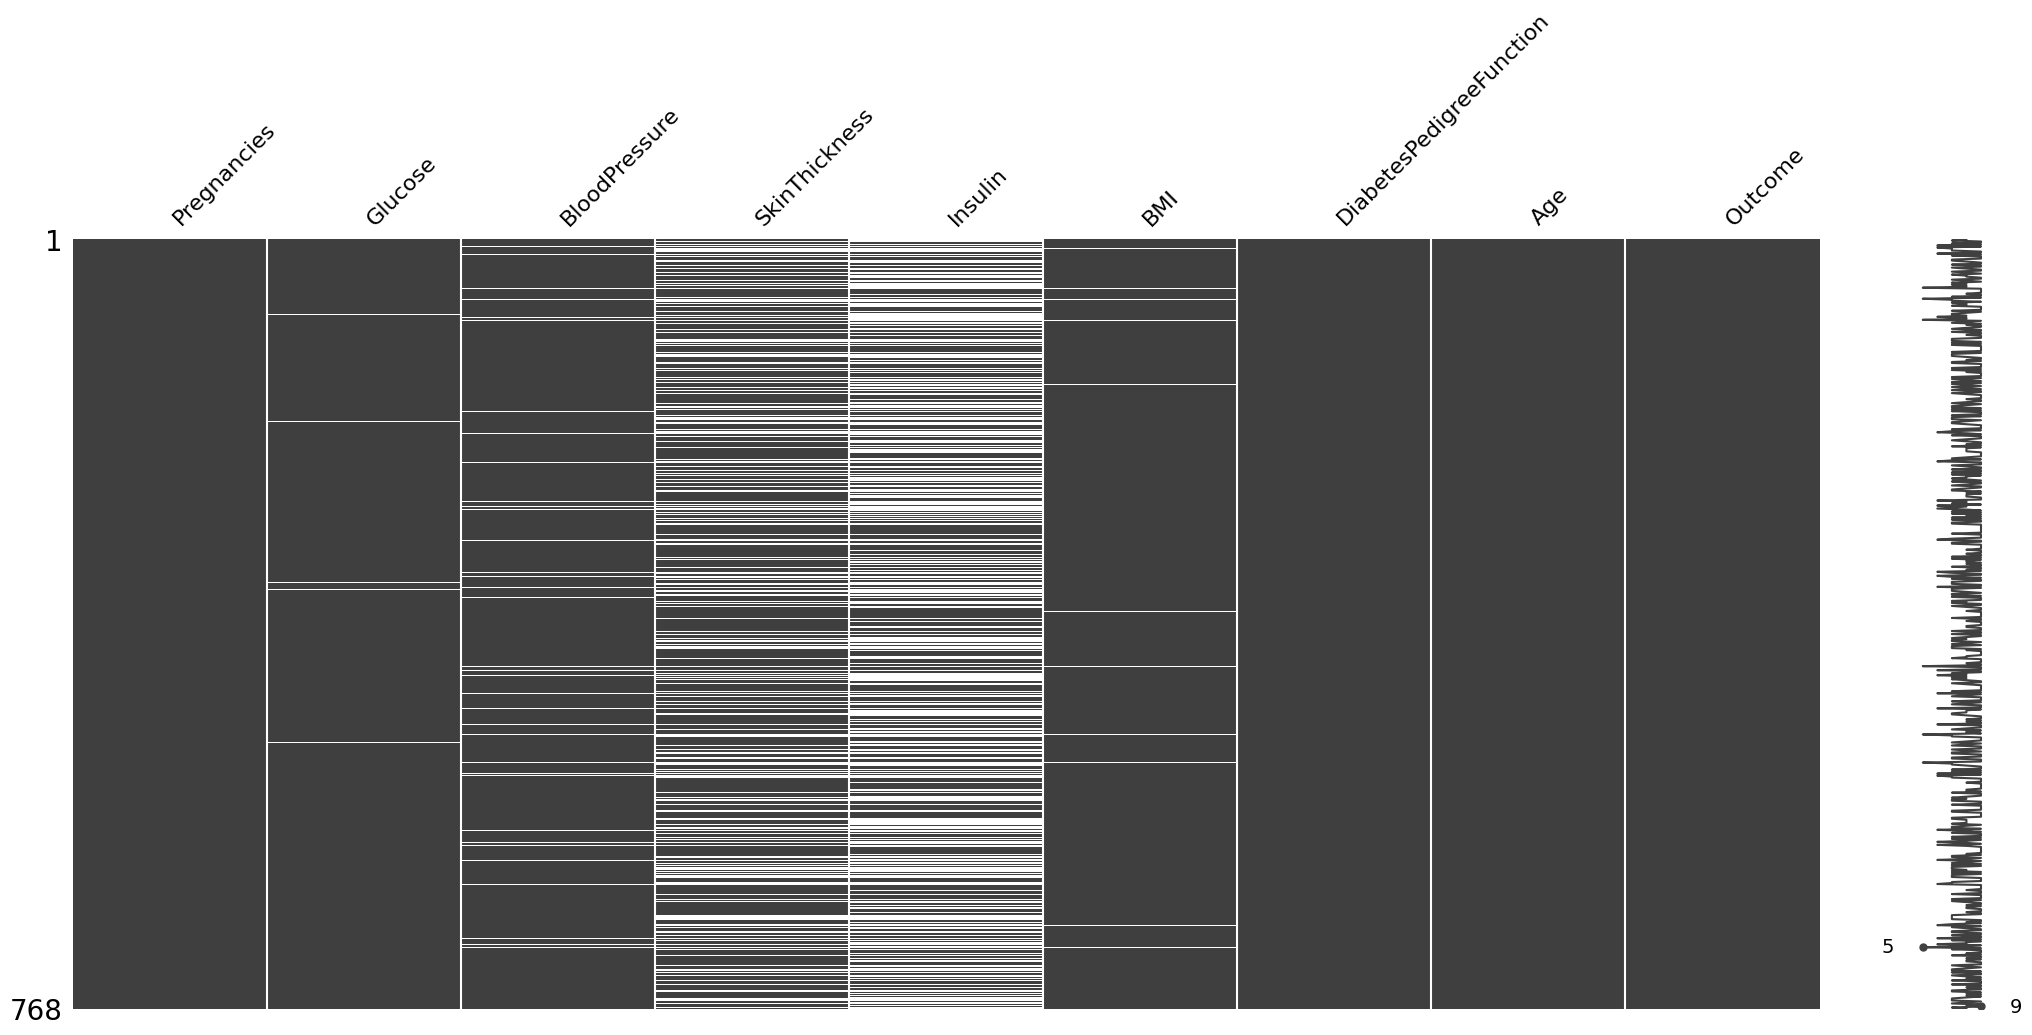

In [669]:
msno.matrix(data)

In [670]:
print(f"{"Kolumna":30}{"ilość braków":<30}{"% braków w kolumnie":<30}")
print("-----------------------------------------------------------------------------------")
for col in data.columns:
    missing = data[col].isna().sum()
    if missing == 0:
        continue
    else:
        percentage_missing = round((missing/len(data[col])) * 100, 4)
        print(f"{col:30}{missing:<30}{percentage_missing:<30}")

Kolumna                       ilość braków                  % braków w kolumnie           
-----------------------------------------------------------------------------------
Glucose                       5                             0.651                         
BloodPressure                 35                            4.5573                        
SkinThickness                 227                           29.5573                       
Insulin                       374                           48.6979                       
BMI                           11                            1.4323                        


### Imputacja metodą KNN

Użyję imputacji metodą K-najbliższych sąsiadów. Proste metody takie jak imputacje średnią czy medianą mogą nie być wystarczająco efektywne przy dużej liczbie braków. KNN uzupełnia braki średnią z k-najbliższych sąsiadów dla brakującej wartości, co pozwala na precyzyjniejszą imputację.

In [671]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [672]:
from sklearn.impute import KNNImputer

In [673]:
knn_imputer = KNNImputer(n_neighbors = 3)
data_imputed = knn_imputer.fit_transform(data)

In [674]:
data_imputed = pd.DataFrame(data_imputed, columns = (data.columns))

In [675]:
data_imputed.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [676]:
data = data_imputed

### Rozkłady predyktorów

In [677]:
import plotly.express as px

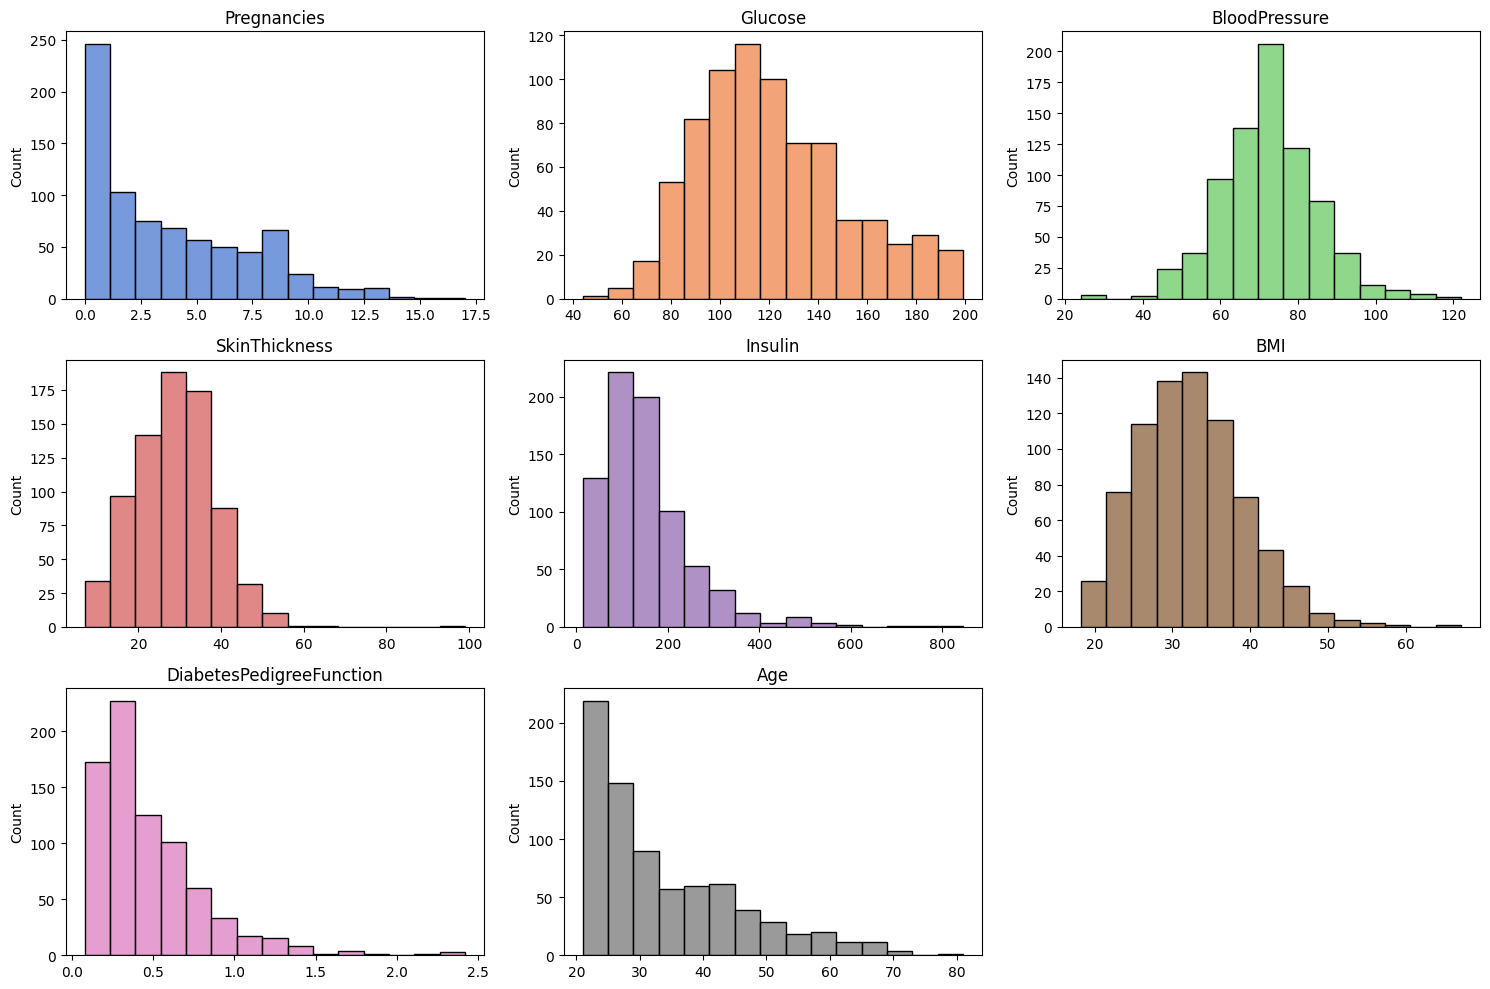

In [678]:
fig, ax = plt.subplots(3, 3, figsize = (15, 10))
palette = sns.color_palette("muted", len(data.columns))
i = 0
j = 0

for col, color in zip(data.columns[:-1], palette):
    sns.histplot(data[col], bins = 15, color = color, ax = ax[i,j])
    ax[i,j].set_title(f"{col}")
    ax[i,j].set_xlabel("")
    j += 1
    if j > 2:
        j = 0
        i += 1
ax[2,2].axis("off")
plt.tight_layout()
plt.show()

In [679]:
import statsmodels.api as sm

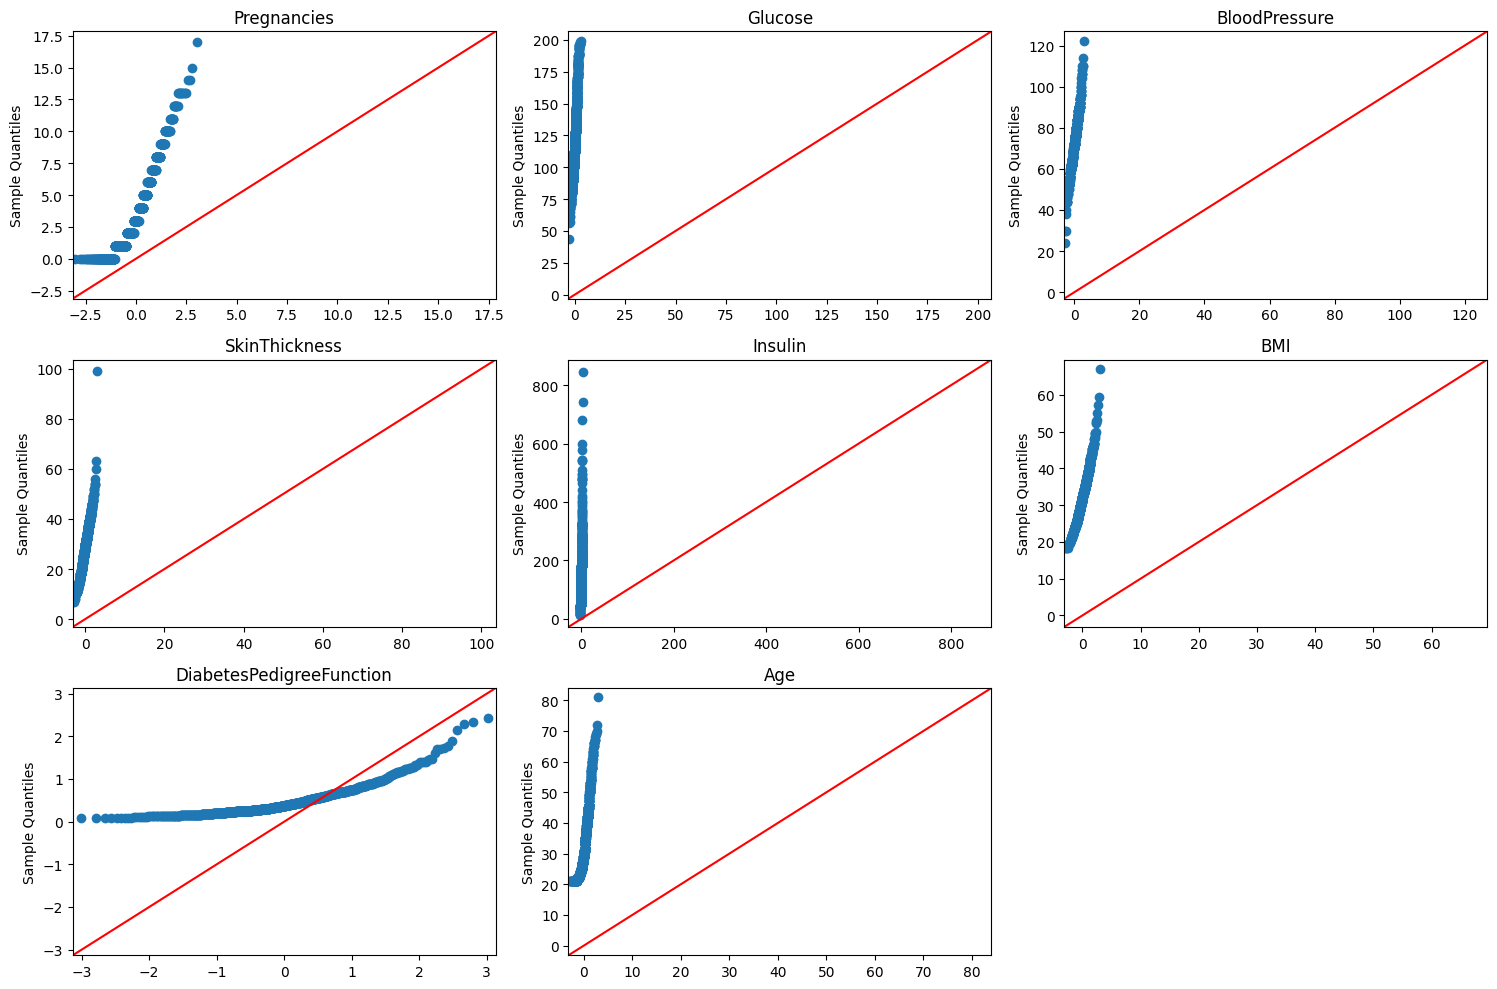

In [680]:
fig, ax = plt.subplots(3, 3, figsize = (15, 10))
i = 0
j = 0

for col in data.columns[:-1]:
    sm.qqplot(data[col], ax = ax[i,j], line="45")
    ax[i,j].set_title(f"{col}")
    ax[i,j].set_xlabel("")
    j += 1
    if j > 2:
        j = 0
        i += 1
ax[2,2].axis("off")
plt.tight_layout()
plt.show()

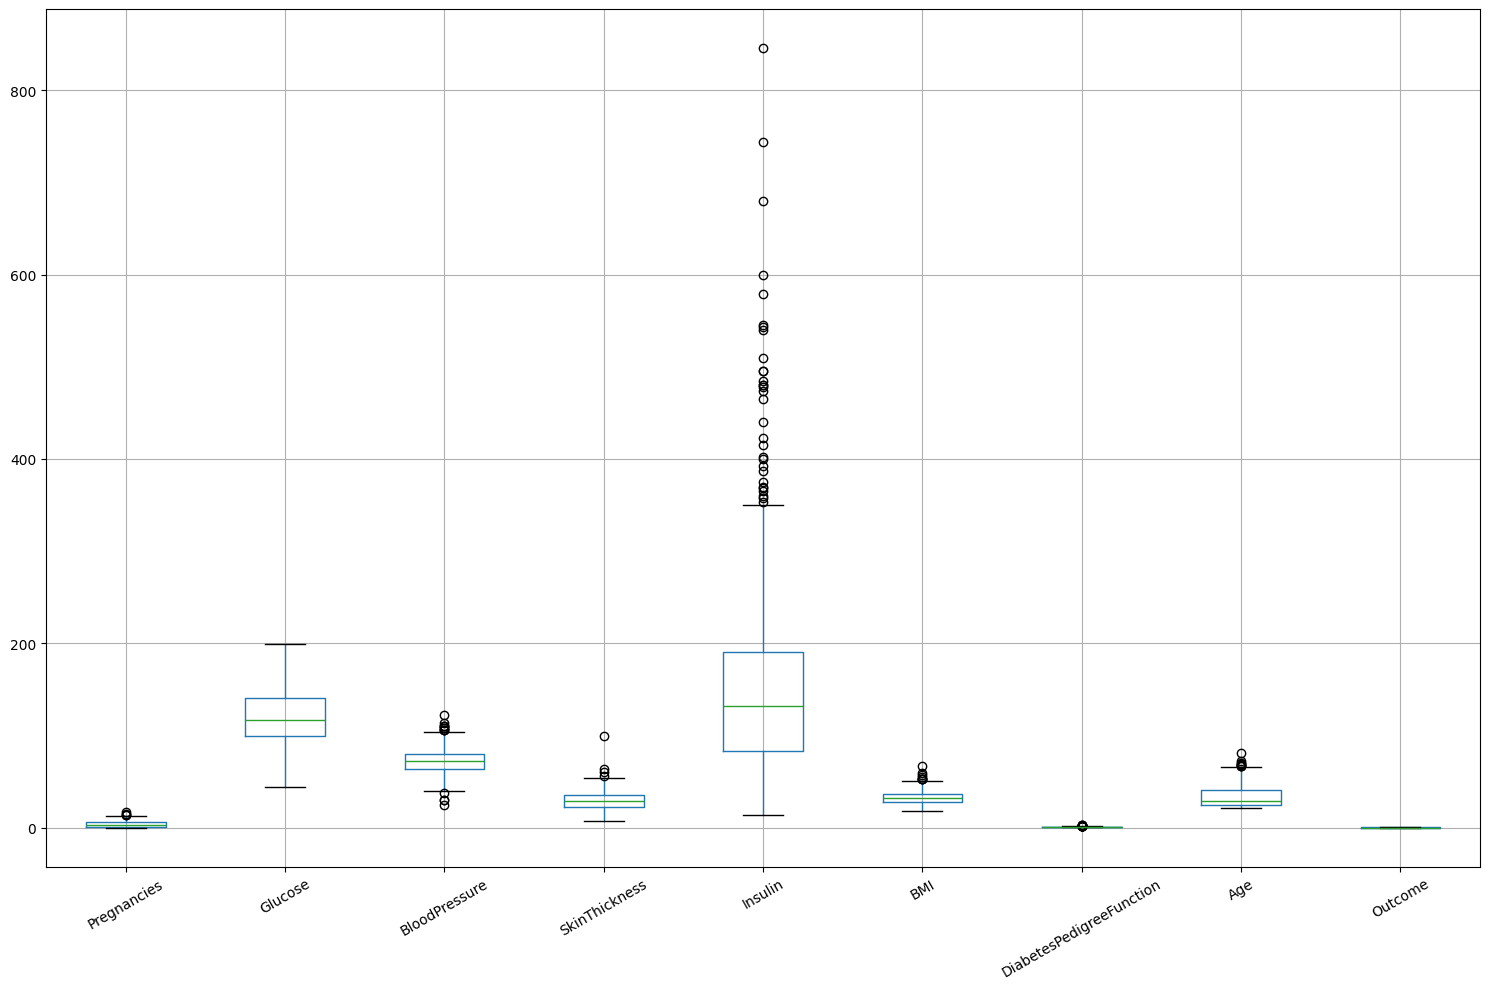

In [681]:
data.boxplot(figsize=(15, 10))
plt.xticks(rotation = 30)
plt.tight_layout()
plt.show()

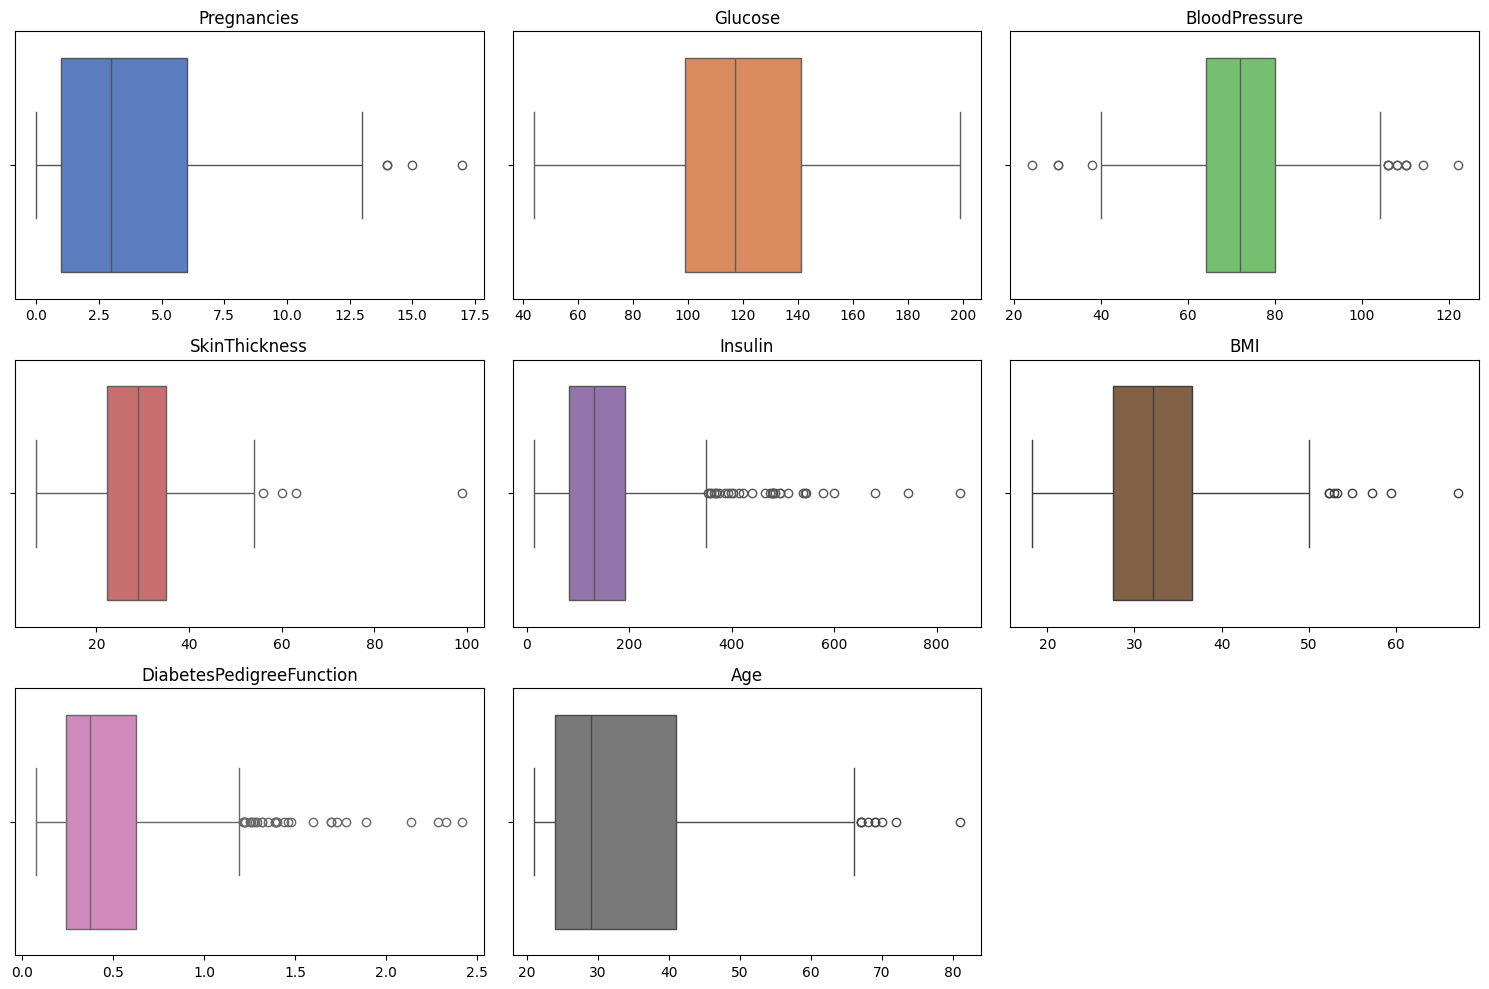

In [682]:
fig, ax = plt.subplots(3, 3, figsize = (15, 10))
palette = sns.color_palette("muted", len(data.columns))
i = 0
j = 0

for col, color in zip(data.columns[:-1], palette):
    sns.boxplot(data[col], color = color, ax = ax[i,j], orient = "h")
    ax[i,j].set_title(f"{col}")
    ax[i,j].set_xlabel("")
    j += 1
    if j > 2:
        j = 0
        i += 1
ax[2,2].axis("off")
plt.tight_layout()
plt.show()

Na pierwszy rzut oka widać, że zmienne posiadają wartości odstające. 

### Test normalności rozkładu

Na przed chwilą ukazanych Q-Q plotach dla zmiennych można zauważyć, że zmienne nie mają rozkładu normalnego. Aby formalnie potwierdzić tę obserwację, użyję testu Shapiro - Wilka, który testuje hipotezę zerową o normalności rozkładu danych. Chcę tym sposobem sprawdzić, czy istnieje możliwość zastosowania metod statystycznych do wykrywania wartości odstających, które zakładają normalność rozkładu, np. metoda wykorzystująca regułę 3 sigm.

In [683]:
from scipy.stats import shapiro

In [684]:
shapiro_result = {}
for col in data.columns[:-1]:
    stat, p = shapiro(data[col])
    shapiro_result[col] = {"Statystyka testowa": stat, "p-value": p}

round(pd.DataFrame(shapiro_result).T, 5)

,Statystyka testowa,p-value
Pregnancies,0.90428,0.00000
Glucose,0.96982,0.00000
BloodPressure,0.98994,0.00004
SkinThickness,0.97299,0.00000
Insulin,0.84615,0.00000
BMI,0.97915,0.00000
DiabetesPedigreeFunction,0.83652,0.00000
Age,0.87477,0.00000


p-value dla każdej zmiennej < 0,05, w związku z tym odrzucam hipotezę zerową. Danie nie mają rozkładu normalnego

### Eliminacja wartosci odstających przy uzyciu *interquartile range* (IQR)

\begin{align*}
T_{\text{min}} &= Q_1 - (c \cdot IQR) \\
T_{\text{max}} &= Q_3 + (c \cdot IQR)
\end{align*}

Gdzie c to stała:
* c = 1,5 dla umiarkowanych wartości odstających
* c = 3 dla ekstremalnych wartości odstających
* IQR = Q3 - Q1

In [685]:
def outlier_test(data, col, c):
    
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    tmin = q1 - (c * iqr)
    tmax = q3 + (c * iqr)
    
    return tmin, tmax

In [686]:
print("Granice wyznaczające wartości odstające:\n")
for col in data.columns[:-1]:
    tmin, tmax = outlier_test(data, col, 1.5)
    print(f"{col}:\nponiżej (Tmin) = {round(tmin, 2)}\npowyżej (Tmax) = {round(tmax, 2)}")
    print("---"*15)

Granice wyznaczające wartości odstające:

Pregnancies:
poniżej (Tmin) = -6.5
powyżej (Tmax) = 13.5
---------------------------------------------
Glucose:
poniżej (Tmin) = 36.0
powyżej (Tmax) = 204.0
---------------------------------------------
BloodPressure:
poniżej (Tmin) = 40.0
powyżej (Tmax) = 104.0
---------------------------------------------
SkinThickness:
poniżej (Tmin) = 3.33
powyżej (Tmax) = 54.0
---------------------------------------------
Insulin:
poniżej (Tmin) = -79.0
powyżej (Tmax) = 353.0
---------------------------------------------
BMI:
poniżej (Tmin) = 13.85
powyżej (Tmax) = 50.25
---------------------------------------------
DiabetesPedigreeFunction:
poniżej (Tmin) = -0.33
powyżej (Tmax) = 1.2
---------------------------------------------
Age:
poniżej (Tmin) = -1.5
powyżej (Tmax) = 66.5
---------------------------------------------


Eliminuje zmienne poniżej wartości Tmin, oraz powyżej wartości Tmax

In [687]:
def remove_outliers(data, c):
    for col in data.columns:
        tmin, tmax = outlier_test(data, col, c)
        data = data[(data[col] >= tmin) & (data[col] <= tmax)]
    return data

In [688]:
data = remove_outliers(data, 1.5)

In [689]:
data.describe().drop(columns = "Outcome")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000
mean,3.760120,118.405797,71.737131,28.546727,136.356322,31.892054,0.424396,32.208396
std,3.244681,28.709385,10.902204,8.980697,71.529707,6.266962,0.245246,10.592367
min,0.000000,44.000000,44.000000,7.000000,15.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,22.000000,79.000000,27.400000,0.237500,24.000000
50%,3.000000,114.000000,72.000000,29.000000,126.000000,32.000000,0.352000,29.000000
75%,6.000000,136.000000,80.000000,35.000000,175.833333,35.900000,0.583000,39.000000
max,13.000000,198.000000,104.000000,54.000000,349.666667,48.300000,1.162000,64.000000


Sprawdzę, czy rozkłady zmiennych zbliżyły się do normalnego po eliminacji outlierów.

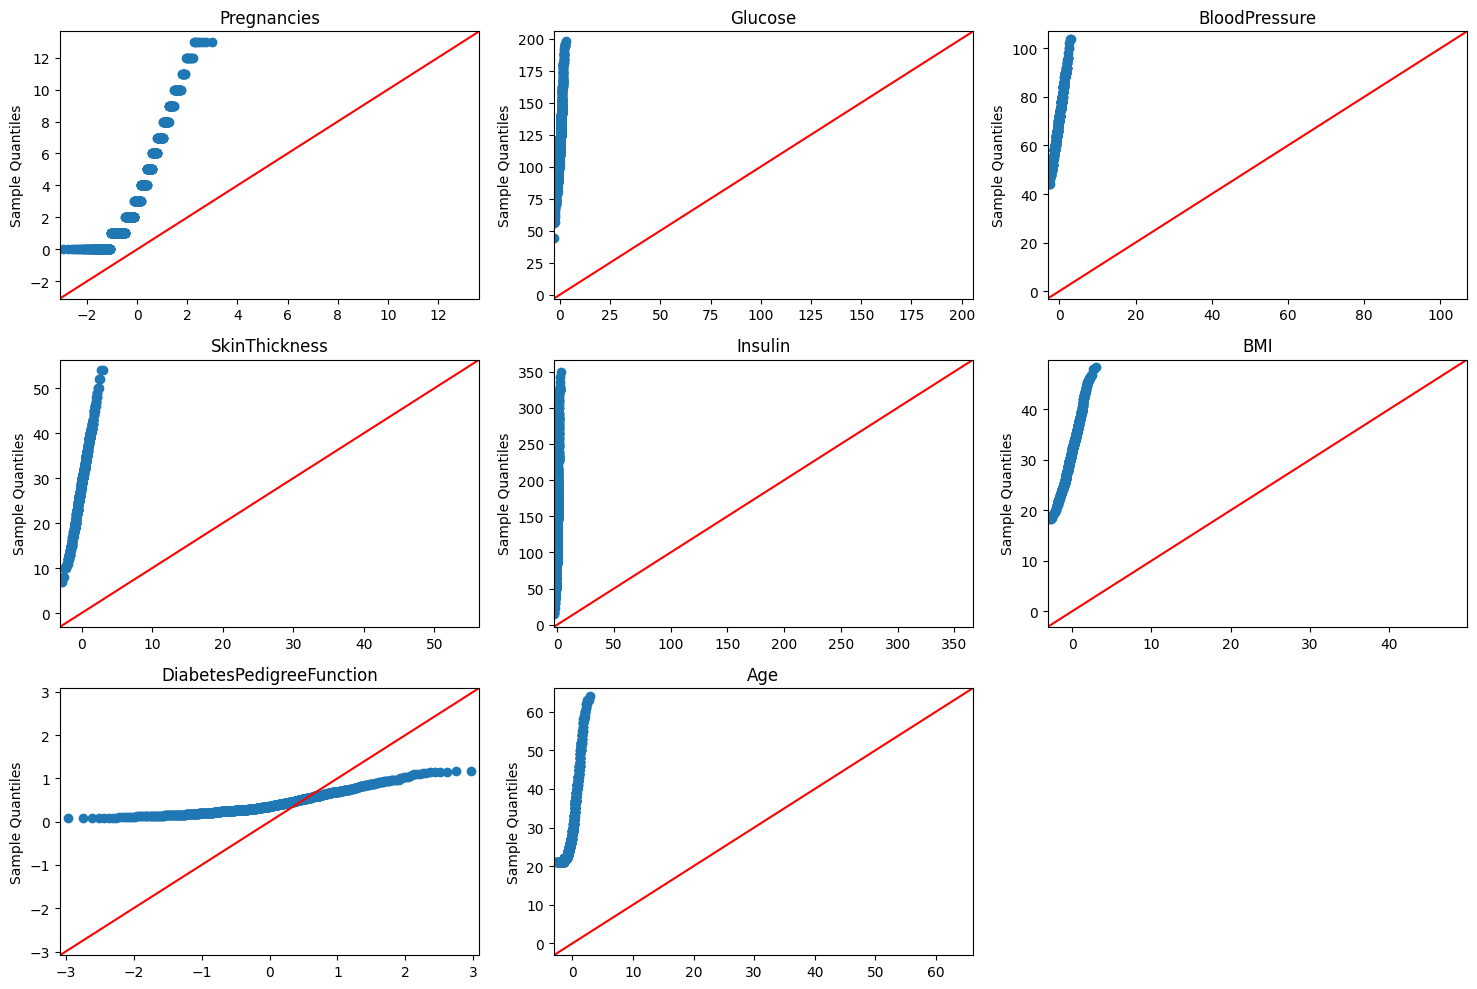

In [690]:
fig, ax = plt.subplots(3, 3, figsize = (15, 10))
i = 0
j = 0

for col in data.columns[:-1]:
    sm.qqplot(data[col], ax = ax[i,j], line="45")
    ax[i,j].set_title(f"{col}")
    ax[i,j].set_xlabel("")
    j += 1
    if j > 2:
        j = 0
        i += 1
ax[2,2].axis("off")
plt.tight_layout()
plt.show()

### Korelacje

Sprawdzę korelacje między parami zmiennych w celu wyeliminowania tych, które są nadmiernie skorelowane. Nadmierna korelacja między zmiennymi mogłaby negatywnie wpłynąć na model.

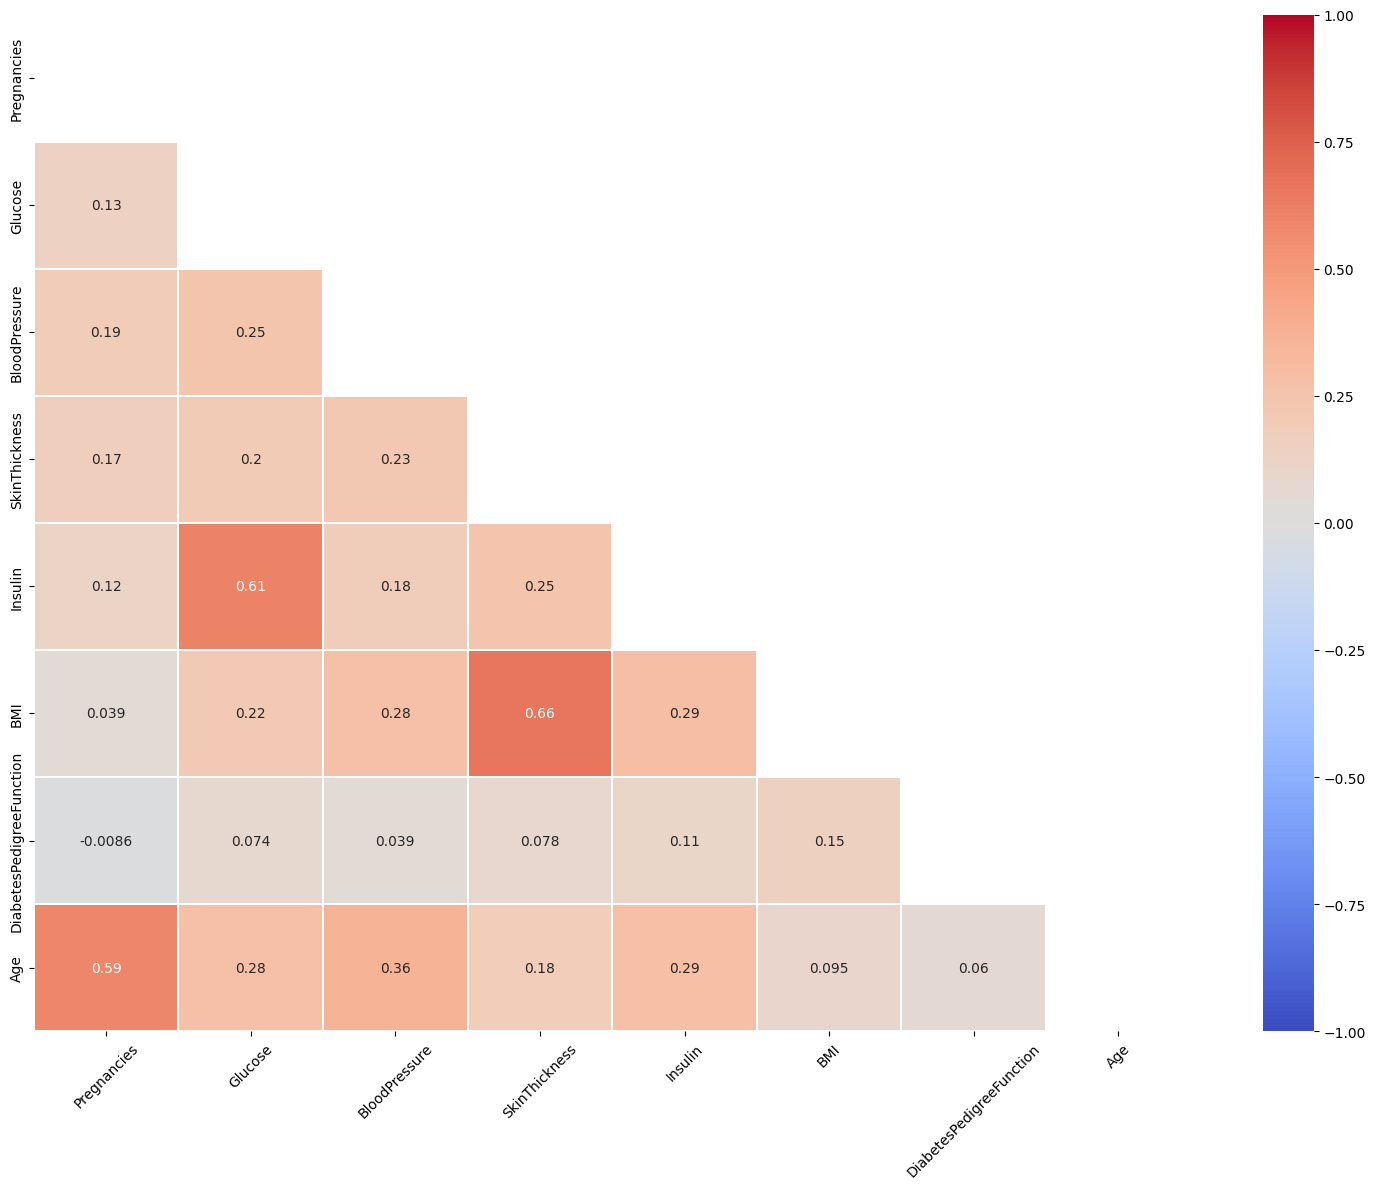

In [691]:
def cor_heatmap(data):
    cor = data.drop(columns = "Outcome").corr(numeric_only = True)
    plt.subplots(figsize = (15, 12))

    mask = np.triu(np.ones_like(cor, dtype = bool))
    cmap = sns.color_palette("coolwarm", as_cmap = True)

    sns.heatmap(cor, cmap = cmap, mask = mask, vmax = 1, vmin = -1, annot = True, linewidths = 0.1)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()

cor_heatmap(data)

Wszystkie korelacje są < 0,7, w związku z tym pozostawiam wszystkie zmienne w analizowanym zbiorze. Najbardziej skorelowanymi zmiennymi ze zmienną objaśnianą *Outcome* są:
1. *Glucose* (0,5)
2. *Insulin* (0,29)

sugeruje to istotność tych zmiennych w modelu klasyfikacji pacjentów z cukrzycą.

### VIF

In [692]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [693]:
x = sm.add_constant(data.drop(columns = "Outcome"))
vif = pd.DataFrame()
vif["cecha"] = x.columns
vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]
vif

,cecha,VIF
0,const,64.641295
1,Pregnancies,1.555743
2,Glucose,1.655428
3,BloodPressure,1.260588
4,SkinThickness,1.852596
5,Insulin,1.714738
6,BMI,1.947231
7,DiabetesPedigreeFunction,1.033918
8,Age,1.815568


Dla każdej zmiennej 1 < VIF < 2,5 - co oznacza, że zmienne nie są współliniowe. Nie eliminuje żadnej zmiennej.

### Podział zbioru na uczący i testowy

In [694]:
from sklearn.model_selection import train_test_split

In [695]:
X = data.drop(columns = "Outcome")
y = data["Outcome"]

In [696]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

## Oszacowanie modeli

### Model logitowy

In [697]:
log_reg_train = sm.Logit(y_train, (sm.add_constant(X_train))).fit()

Optimization terminated successfully.
         Current function value: 0.446316
         Iterations 6


In [698]:
print(log_reg_train.summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  466
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            8
Date:                Sun, 28 Jul 2024   Pseudo R-squ.:                  0.2914
Time:                        21:38:41   Log-Likelihood:                -207.98
converged:                       True   LL-Null:                       -293.52
Covariance Type:            nonrobust   LLR p-value:                 7.674e-33
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -10.1111      1.190     -8.495      0.000     -12.444      -7.778
Pregnancies                  0.1134      0.043      2.631      0.009       0.029       0.

In [699]:
print(f"AIC: {round(log_reg_train.aic, 2)}")

AIC: 433.97


* **Kryterium Akaike'a** wynosi 433,97 (im niższa wartość kryterium, tym lepszy model).

1. **Pregnancies: 0,1134**
    * Istotność statystyczna na poziomie istotności 0,01 (p = 0,009)

2. **Glucose: 0,0384**
    * Istotność statystyczna na poziomie istotności 0,01 (p < 0,01)

3. **BloodPressure: 0,0043**
    * Brak istotności statystycznej (p = 0,735)
    
4. **SkinThickness: 0,0097**
    * Brak istotności statystycznej (p = 0,604)

5. **Insulin: 0,0005**
    * Brak istotności statystycznej (p = 0,796)

6. **BMI: 0,0705**
    * Istotność statystyczna na poziomie istotności 0,01 (p = 0,010)

7. **DiabetesPedigreeFunction: 1,0058**
    * Istotność statystyczna na poziomie istotności 0,05 (p = 0,040)

8. **Age: 0,0234**
    * Brak istotności statystycznej (p = 0,093)

* Miara dopasowania (pseudo R^2) - wynosi 0,2914, co oznacza, że model stosunkowo słabo wyjaśnia zmienność w danych.
* LLR p-value, tj. p value dla testu ilorazu wiarygodności dla modelu zerowego (uwzględniającego tylko stałą) oraz pełnego wynosi 7,674e-33, co oznacza, że pełny model jest lepszy od modelu zerowego.

### Test ilorazu wiarygodności (LR TEST)

Porównam teraz model zagnieżdżony z ograniczoną liczbą predyktorów (uwzględnie tylko istotnie statystyczne zmienne) oraz pełny model.

iloraz wiarygoności pełnego modelu

In [700]:
full_llf = log_reg_train.llf # iloraz wiarygodności

iloraz wiarygodności modelu zredukowanego

In [701]:
X_reduced = X_train[["BloodPressure", "SkinThickness", "Insulin"]]

In [702]:
X_reduced = X_train.drop(columns = ["BloodPressure", "SkinThickness", "Insulin"])

In [703]:
reduced_model = sm.Logit(y_train, X_reduced).fit()

Optimization terminated successfully.
         Current function value: 0.613026
         Iterations 5


In [704]:
reduced_llf = reduced_model.llf # iloraz wiarygodności
reduced_llf

-285.67015388654386

In [705]:
lr_stat = -2*(reduced_llf - full_llf)
lr_stat

155.374184252468

In [706]:
df = sm.add_constant(X_train).shape[1] - sm.add_constant(X_reduced).shape[1] # liczba stopni swobody to różnica między ilością predyktorów w modelach

In [707]:
p_value = stats.chi2.sf(lr_stat, df)

In [708]:
print(f"p-value: {p_value}")

p-value: 1.8252515323655908e-33


Jak widać po wartości p value, zmienne *BloodPressure, SkinThickness i Insulin* wnoszą coś nowego do modelu, w związku z tym pozostawiam wszystkie zmiennne w modelu.

#### Estymacja najlepszego możliwego modelu pod względem kryterium informacyjnego Akaike'a, za pomocą iteracji przez wszystkie możliwe kombinacje predyktorów.

In [709]:
import itertools

In [710]:
predictorcols = X_train.columns.tolist()
min_aic = float("inf") # nieskończoność jako benchmark, do której będę porównywać kolejne wartości AIC w celu znalezienia najniższej wartości

for k in range(1, len(predictorcols) + 1):
    for variables in itertools.combinations(predictorcols, k):
        predictors = list(variables)
        model = sm.Logit(y_train, sm.add_constant(X_train[predictors])).fit(disp = 0)
        if model.aic < min_aic:
            min_aic = model.aic
            best_predictors = predictors
print(f"Najlepszy model\n\nPredyktory: {best_predictors}\nAIC: {round(min_aic, 2)}")

Najlepszy model

Predyktory: ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']
AIC: 428.41


Jak widać powyżej, udało się uzyskać lepszy model pod względem kryterium Akaike'a.

In [711]:
log_reg_train = sm.Logit(y_train, sm.add_constant(X_train[best_predictors])).fit()

Optimization terminated successfully.
         Current function value: 0.446796
         Iterations 6


### Statystyka Walda

In [712]:
from scipy import stats

In [713]:
result_wald = {}
for i, param, std_error in zip(log_reg_train.params.index, log_reg_train.params.values, log_reg_train.bse.values):
    w = (param / std_error)**2
    p_value = stats.chi2.sf(w, df = 1)
    result_wald[i] = {"statystyka Walda": w, "p_value": p_value}

result_wald = round(pd.DataFrame(result_wald).T, 4)
result_wald

,statystyka Walda,p_value
const,95.7107,0.0000
Pregnancies,7.0800,0.0078
Glucose,62.8904,0.0000
BMI,15.2103,0.0001
DiabetesPedigreeFunction,4.3293,0.0375
Age,3.7697,0.0522


#### Interpretacja modelu logitowego

In [714]:
from math import exp

In [715]:
for i, (param, coef) in enumerate(log_reg_train.params.items()):
    if param == "const":
        continue
    print(f"{i}. Zmiana {param} o jedną jednostkę powoduje wzrost szansy na wystąpienie cukrzycy o {round((exp(coef) - 1)*100, 2)}%, ceteris paribus.")

1. Zmiana Pregnancies o jedną jednostkę powoduje wzrost szansy na wystąpienie cukrzycy o 12.1%, ceteris paribus.
2. Zmiana Glucose o jedną jednostkę powoduje wzrost szansy na wystąpienie cukrzycy o 4.02%, ceteris paribus.
3. Zmiana BMI o jedną jednostkę powoduje wzrost szansy na wystąpienie cukrzycy o 8.52%, ceteris paribus.
4. Zmiana DiabetesPedigreeFunction o jedną jednostkę powoduje wzrost szansy na wystąpienie cukrzycy o 174.89%, ceteris paribus.
5. Zmiana Age o jedną jednostkę powoduje wzrost szansy na wystąpienie cukrzycy o 2.58%, ceteris paribus.


### Model probitowy

In [716]:
prob_reg_train = sm.Probit(y_train, (sm.add_constant(X_train))).fit()

Optimization terminated successfully.
         Current function value: 0.443737
         Iterations 6


In [717]:
print(prob_reg_train.summary())

                          Probit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  466
Model:                         Probit   Df Residuals:                      457
Method:                           MLE   Df Model:                            8
Date:                Sun, 28 Jul 2024   Pseudo R-squ.:                  0.2955
Time:                        21:38:42   Log-Likelihood:                -206.78
converged:                       True   LL-Null:                       -293.52
Covariance Type:            nonrobust   LLR p-value:                 2.405e-33
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -6.0019      0.664     -9.039      0.000      -7.303      -4.701
Pregnancies                  0.0681      0.024      2.798      0.005       0.020       0.

In [718]:
print(f"AIC: {round(prob_reg_train.aic, 2)}")

AIC: 431.56


In [719]:
predictorcols = X_train.columns.tolist()
min_aic = float("inf")

for k in range(1, len(predictorcols) + 1):
    for variables in itertools.combinations(predictorcols, k):
        predictors = list(variables)
        model = sm.Probit(y_train, sm.add_constant(X_train[predictors])).fit(disp = 0)
        if model.aic < min_aic:
            min_aic = model.aic
            best_predictors = predictors
print(f"Najlepszy model\n\nPredyktory: {best_predictors}\nAIC: {round(min_aic, 2)}")

Najlepszy model

Predyktory: ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']
AIC: 426.14


In [720]:
prob_reg_train = sm.Probit(y_train, sm.add_constant(X_train[best_predictors])).fit()

Optimization terminated successfully.
         Current function value: 0.444360
         Iterations 6


### Statystyka Walda

In [721]:
result_wald = {}
for i, param, std_error in zip(prob_reg_train.params.index, prob_reg_train.params.values, prob_reg_train.bse.values):
    w = (param / std_error)**2
    p_value = stats.chi2.sf(w, df = 1)
    result_wald[i] = {"statystyka Walda": w, "p_value": p_value}

result_wald = round(pd.DataFrame(result_wald).T, 4)
result_wald

,statystyka Walda,p_value
const,114.2330,0.0000
Pregnancies,8.1128,0.0044
Glucose,69.2116,0.0000
BMI,15.4952,0.0001
DiabetesPedigreeFunction,4.1260,0.0422
Age,4.0310,0.0447


### Interpretacja modelu probitowego

Interpretacja parametrów modelu probitowego sprowadza się do stwierdzenia czy dana zmienna jest stymulantą (gdy parametr > 0), czy destmulantą (gdy parametr < 0). Kierując się tą zasadą, każda zmienna w modelu probitowym jest stymulantą i jej wzrost powoduje wzrost prawdopodobieństwa wystąpienia cukrzycy.

## Ocena modeli

### Pórównanie jakości dopasowania modelu logitowego i probitowego

Zbiór uczący:

In [722]:
print(f"{"Model logitowy":10}{"Model probitowy":>20}\n")
print(f"R^2:{round(log_reg_train.prsquared, 4):10}{round(prob_reg_train.prsquared, 4):>20}")
print(f"AIC:{round(log_reg_train.aic, 4):10}{round(prob_reg_train.aic, 4):>20}")

Model logitowy     Model probitowy

R^2:    0.2907              0.2945
AIC:  428.4135            426.1438


Zbiór testowy:

In [723]:
log_reg_test = sm.Logit(y_test, (sm.add_constant(X_test[best_predictors]))).fit()
prob_reg_test = sm.Probit(y_test, (sm.add_constant(X_test[best_predictors]))).fit()

Optimization terminated successfully.
         Current function value: 0.424143
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424502
         Iterations 6


In [724]:
print(f"{"Model logitowy":10}{"Model probitowy":>20}\n")
print(f"R^2:{round(log_reg_test.prsquared, 4):10}{round(prob_reg_test.prsquared, 4):>20}")
print(f"AIC:{round(log_reg_test.aic, 4):10}{round(prob_reg_test.aic, 4):>20}")

Model logitowy     Model probitowy

R^2:    0.3042              0.3036
AIC:  182.5053            182.6496


Model probitowy okazuje się być nieco lepiej dopasownym na zbiorze uczącym, z kolei model logitowy okazuje się lepszy na zbiorze testowym.

### Ocena jakości predykcji modelu logitowego i probitowego

In [725]:
from sklearn.metrics import confusion_matrix, accuracy_score 

Jako domyślną wartość punktu odcięcia, czyli granicy w prawdopodobieństwie klasyfikacji, pomiędzy klasą 1, a 0 (wystąpienie cukrzycy - brak cukrzycy) wybiorę 0,5. Uważam to za bezpieczną wartość odcięcia traktując pozytywne i negatywne przypadki z równą wagą.

In [726]:
def conf_matrix_df(y, log_pred, prob_pred, p = 0.5):
    log_binary = np.where(log_pred >= p, 1, 0)
    prob_binary = np.where(prob_pred >= p, 1, 0)

    log_conf_matrix = confusion_matrix(y, log_binary)
    prob_conf_matrix = confusion_matrix(y, prob_binary)

    log_conf_matrix_df = pd.DataFrame(log_conf_matrix, 
                                      index=["obserwowane 0", "obserwowane 1"], 
                                      columns=["przewidywane 0", "przewidywane 1"])
    prob_conf_matrix_df = pd.DataFrame(prob_conf_matrix, 
                                       index=["obserwowane 0", "obserwowane 1"], 
                                       columns=["przewidywane 0", "przewidywane 1"])
                                           
    return log_conf_matrix_df, prob_conf_matrix_df

#### Funkcja do obliczenia miar opartych na tablicy trafności

In [727]:
def model_scores(conf_matrix_df: "pd.dataframe"):

    n00 = conf_matrix_df.at["obserwowane 0", "przewidywane 0"]
    n01 = conf_matrix_df.at["obserwowane 0", "przewidywane 1"]
    n10 = conf_matrix_df.at["obserwowane 1", "przewidywane 0"]
    n11 = conf_matrix_df.at["obserwowane 1", "przewidywane 1"]

    n = n00 + n01 + n10 + n11

    accuracy = (n00 + n11) / n
    error_rate = (n01 + n10) / n
    sensitivity = n11 / (n11 + n10)
    specificity = n00 / (n00 + n01)
    ppv = n11 / (n11 + n01)
    npv = n00 / (n00 + n10)

    result = {
        "accuracy": accuracy,
        "error_rate": error_rate,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "ppv": ppv,
        "npv": npv
    }

    print("Accuracy:", result["accuracy"])
    print("Error rate:", result["error_rate"])
    print("Sensitivity:", result["sensitivity"])
    print("Specificity:", result["specificity"])
    print("PPV:", result["ppv"])
    print("NPV:", result["npv"])

#### Zbiór uczący

In [728]:
log_reg_train_pred = log_reg_train.predict(sm.add_constant(X_train[best_predictors])) 
prob_reg_train_pred = prob_reg_train.predict(sm.add_constant(X_train[best_predictors]))

In [729]:
log_reg_train_conf_matrix_df, prob_reg_train_conf_matrix_df = conf_matrix_df(y_train, log_reg_train_pred, prob_reg_train_pred)

In [730]:
log_reg_train_conf_matrix_df

,przewidywane 0,przewidywane 1
obserwowane 0,281,34
obserwowane 1,70,81


In [731]:
prob_reg_train_conf_matrix_df

,przewidywane 0,przewidywane 1
obserwowane 0,281,34
obserwowane 1,70,81


In [732]:
model_scores(log_reg_train_conf_matrix_df)

Accuracy: 0.776824034334764
Error rate: 0.22317596566523606
Sensitivity: 0.5364238410596026
Specificity: 0.8920634920634921
PPV: 0.7043478260869566
NPV: 0.8005698005698005


In [733]:
model_scores(prob_reg_train_conf_matrix_df)

Accuracy: 0.776824034334764
Error rate: 0.22317596566523606
Sensitivity: 0.5364238410596026
Specificity: 0.8920634920634921
PPV: 0.7043478260869566
NPV: 0.8005698005698005


Jak widać, przy punkcie odcięcia p = 0,5, tablice trafności, a co za tym idzie, miary jakości predykcji w modelu logitowym i probitowym dla zbioru uczącego są takie same.

* Accuracy: 0,7768
    * Model poprawnie klasyfikuje około 77,68% wszystkich przypadków. *Accuracy* jest miarą ogólnej skuteczności modelu.

* Error rate: 0,2232
    * Model popełnia błędy w klasyfikacji około 22,32% wszystkich przypadków (1 - *accuracy*).

* Sensitivity: 0,5364
    * Model poprawnie identyfikuje około 53,64% przypadków pozytywnych (osób chorych).

* Specificity: 0,8921
    * Model poprawnie identyfikuje około 89,21% przypadków negatywnych (osób zdrowych).

* PPV (dodatnia zdolność predykcyjna): 0,7043
    * Kiedy model przewiduje pozytywny wynik (osoba chora), jest on poprawny w około 70,43% przypadków.

* NPV (ujemna zdolność predykcyjna): 0,8006
    * Kiedy model przewiduje negatywny (osoba zdrowa) wynik, jest on poprawny w około 80,06% przypadków.

W kontekście wykrywania chorób, maksymalizacja *sensitivity* tj. czułości jest najrozsądniejsza. Niska czułość prowadzi do wysokiej liczby fałszywych 0, tzn. sytuacji, w której choroba nie zostaje wykryta. Maksymalizacja czułości prowadzi również do zmniejszenia *specificity* czyli swoistości, co może mieć negatywne konsekwencje w związku z większą liczbą fałszywie pozytywnych wyników, które mogą prowadzić do dodatkowych kosztów związanych z koniecznością przeprowadzenia kolejnych badań. W związku z powyższym wypróbuję różne punkty odcięcia, znajdując kompromis pomiędzy czułością, a swoistością.

In [734]:
log_reg_train_conf_matrix_df, prob_reg_train_conf_matrix_df = conf_matrix_df(y_train, log_reg_train_pred, prob_reg_train_pred, p = 0.4)

In [735]:
model_scores(log_reg_train_conf_matrix_df)

Accuracy: 0.7746781115879828
Error rate: 0.22532188841201717
Sensitivity: 0.6291390728476821
Specificity: 0.8444444444444444
PPV: 0.6597222222222222
NPV: 0.8260869565217391


In [736]:
model_scores(prob_reg_train_conf_matrix_df)

Accuracy: 0.776824034334764
Error rate: 0.22317596566523606
Sensitivity: 0.6357615894039735
Specificity: 0.8444444444444444
PPV: 0.6620689655172414
NPV: 0.8286604361370716


In [737]:
log_reg_train_conf_matrix_df, prob_reg_train_conf_matrix_df = conf_matrix_df(y_train, log_reg_train_pred, prob_reg_train_pred, p = 0.3)

In [738]:
model_scores(log_reg_train_conf_matrix_df)

Accuracy: 0.740343347639485
Error rate: 0.259656652360515
Sensitivity: 0.7417218543046358
Specificity: 0.7396825396825397
PPV: 0.5773195876288659
NPV: 0.8566176470588235


In [739]:
model_scores(prob_reg_train_conf_matrix_df)

Accuracy: 0.740343347639485
Error rate: 0.259656652360515
Sensitivity: 0.7549668874172185
Specificity: 0.7333333333333333
PPV: 0.5757575757575758
NPV: 0.8619402985074627


Używając punktu odcięcia p = 0,3 udało się uzyskać kompromis między czułością, a swoistością, zachowując przy tym stosunkowo rozsądne wartości innych miar.

#### Zbiór testowy

In [740]:
log_reg_test_pred = log_reg_test.predict(sm.add_constant(X_test[best_predictors])) 
prob_reg_test_pred = prob_reg_test.predict(sm.add_constant(X_test[best_predictors]))

In [741]:
log_reg_test_conf_matrix_df, prob_reg_test_conf_matrix_df = conf_matrix_df(y_test, log_reg_test_pred, prob_reg_test_pred, p = 0.3)

In [742]:
log_reg_test_conf_matrix_df

,przewidywane 0,przewidywane 1
obserwowane 0,111,30
obserwowane 1,15,45


In [743]:
prob_reg_test_conf_matrix_df

,przewidywane 0,przewidywane 1
obserwowane 0,109,32
obserwowane 1,15,45


In [744]:
model_scores(log_reg_test_conf_matrix_df)

Accuracy: 0.7761194029850746
Error rate: 0.22388059701492538
Sensitivity: 0.75
Specificity: 0.7872340425531915
PPV: 0.6
NPV: 0.8809523809523809


In [745]:
model_scores(prob_reg_test_conf_matrix_df)

Accuracy: 0.7661691542288557
Error rate: 0.23383084577114427
Sensitivity: 0.75
Specificity: 0.7730496453900709
PPV: 0.5844155844155844
NPV: 0.8790322580645161


Na podstawie powyższych wyników ciężko stwierdzić, który model jest lepszy z racji minimalnych różnic, dlatego przejdę od razu do sprawdzenia jakości predykcji na podstawie krzywej ROC.

### Krzywa ROC i miara AUC

In [746]:
from sklearn.metrics import roc_curve, auc

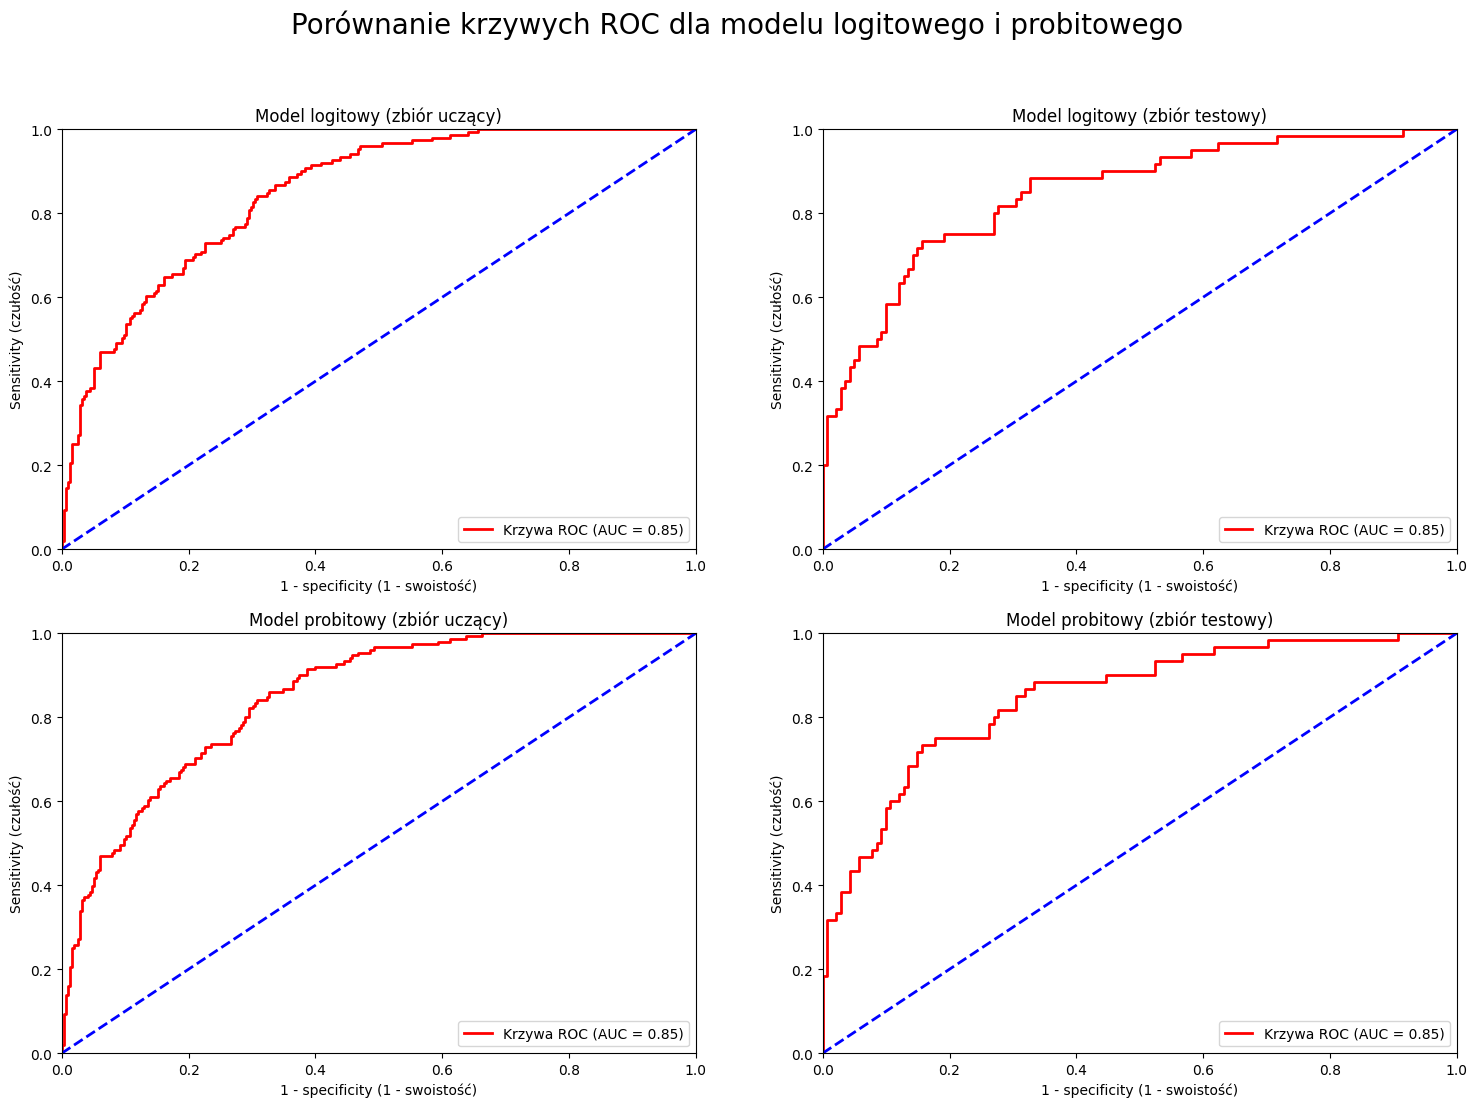

In [747]:
# logit uczacy
fpr_log_reg_train, tpr_log_reg_train, _ = roc_curve(y_train, log_reg_train_pred)
roc_auc_log_reg_train = auc(fpr_log_reg_train, tpr_log_reg_train)

# logit testowy
fpr_log_reg_test, tpr_log_reg_test, _ = roc_curve(y_test, log_reg_test_pred)
roc_auc_log_reg_test = auc(fpr_log_reg_test, tpr_log_reg_test)

# probit uczacy
fpr_prob_reg_train, tpr_prob_reg_train, _ = roc_curve(y_train, prob_reg_train_pred)
roc_auc_prob_reg_train = auc(fpr_prob_reg_train, tpr_prob_reg_train)

# probit testowy
fpr_prob_reg_test, tpr_prob_reg_test, _ = roc_curve(y_test, prob_reg_test_pred)
roc_auc_prob_reg_test = auc(fpr_prob_reg_test, tpr_prob_reg_test)


fig, ax = plt.subplots(2, 2, figsize=(18, 12))
# logi uczacy
ax[0, 0].plot(fpr_log_reg_train, tpr_log_reg_train, color="red", lw=2, label=f"Krzywa ROC (AUC = {roc_auc_log_reg_train:.2f})")
ax[0, 0].plot([0, 1], [0, 1], color="blue", lw=2, linestyle="--")
ax[0, 0].set_xlim([0.0, 1.0])
ax[0, 0].set_ylim([0.0, 1.0])
ax[0, 0].set_xlabel("1 - specificity (1 - swoistość)")
ax[0, 0].set_ylabel("Sensitivity (czułość)")
ax[0, 0].set_title("Model logitowy (zbiór uczący)")
ax[0, 0].legend(loc="lower right")
# logit testowy
ax[0, 1].plot(fpr_log_reg_test, tpr_log_reg_test, color="red", lw=2, label=f"Krzywa ROC (AUC = {roc_auc_log_reg_test:.2f})")
ax[0, 1].plot([0, 1], [0, 1], color="blue", lw=2, linestyle="--")
ax[0, 1].set_xlim([0.0, 1.0])
ax[0, 1].set_ylim([0.0, 1.0])
ax[0, 1].set_xlabel("1 - specificity (1 - swoistość)")
ax[0, 1].set_ylabel("Sensitivity (czułość)")
ax[0, 1].set_title("Model logitowy (zbiór testowy)")
ax[0, 1].legend(loc="lower right")
# probit uczacy
ax[1, 0].plot(fpr_prob_reg_train, tpr_prob_reg_train, color="red", lw=2, label=f"Krzywa ROC (AUC = {roc_auc_prob_reg_train:.2f})")
ax[1, 0].plot([0, 1], [0, 1], color="blue", lw=2, linestyle="--")
ax[1, 0].set_xlim([0.0, 1.0])
ax[1, 0].set_ylim([0.0, 1.0])
ax[1, 0].set_xlabel("1 - specificity (1 - swoistość)")
ax[1, 0].set_ylabel("Sensitivity (czułość)")
ax[1, 0].set_title("Model probitowy (zbiór uczący)")
ax[1, 0].legend(loc="lower right")
# probit testowy
ax[1, 1].plot(fpr_prob_reg_test, tpr_prob_reg_test, color="red", lw=2, label=f"Krzywa ROC (AUC = {roc_auc_prob_reg_test:.2f})")
ax[1, 1].plot([0, 1], [0, 1], color="blue", lw=2, linestyle="--")
ax[1, 1].set_xlim([0.0, 1.0])
ax[1, 1].set_ylim([0.0, 1.0])
ax[1, 1].set_xlabel("1 - specificity (1 - swoistość)")
ax[1, 1].set_ylabel("Sensitivity (czułość)")
ax[1, 1].set_title("Model probitowy (zbiór testowy)")
ax[1, 1].legend(loc="lower right")

fig.suptitle("Porównanie krzywych ROC dla modelu logitowego i probitowego", fontsize=20)
plt.show()

In [748]:
print("Model logitowy:")
print(f"AUC dla zbioru uczącego: {roc_auc_log_reg_train:.4f}")
print(f"AUC dla zbioru testowego: {roc_auc_log_reg_test:.4f}\n")
print("Model probitowy:")
print(f"AUC dla zbioru uczącego: {roc_auc_prob_reg_train:.4f}")
print(f"AUC dla zbioru testowego: {roc_auc_prob_reg_test:.4f}\n")

Model logitowy:
AUC dla zbioru uczącego: 0.8491
AUC dla zbioru testowego: 0.8482

Model probitowy:
AUC dla zbioru uczącego: 0.8493
AUC dla zbioru testowego: 0.8489



Różnice między modelami logitowym i probitowym są znikome. Jednak model probitowy na zbiorze testowym lepiej radzi sobie z predykcjami, co pokazuje większe pole powierzchni pod krzywą ROC.

## Podsumowanie

Model probitowy wykazał lepszą jakość predykcji na zbiorze testowym w pórownaniu do modelu logitowego, natomiast uwzględniając intuicyjną interpretacje parametrów za pomocą ilorazów szans jaką oferuje model logitowy, uważam, że do modelowania prawdopodobieństwa wystąpienia cukrzycy u pacjenta model logitowy jest bardziej odpowiedni.

## Źródła

* [Dane użyte do analizy](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)
* https://stackoverflow.com/questions/22428625/does-statsmodels-or-another-python-package-offer-an-equivalent-to-rs-step-f
* https://scikit-learn.org/0.21/user_guide.html
* https://www.statology.org/likelihood-ratio-test-in-python/
* https://www.geeksforgeeks.org/qqplot-quantile-quantile-plot-in-python/
* https://www.statsmodels.org/stable/user-guide.html